## Import

In [219]:
import pandas as pd
import numpy as np
import csv
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
# Make the graphs a bit prettier, and bigger
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Function definition

In [2]:
def save_to_pickle_file(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_pickle_file(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [113]:
# read solution
def read_solution(filename):
    with open(filename, 'r') as sol_file:
        reader = csv.reader(sol_file, delimiter=' ', skipinitialspace=True)
        cost_sol = []
        
        for row in reader:
            cost_sol.append(int(row[2]))
            
        return cost_sol

def bruteforce(n, M, pairs, print_out=True, repeat_num=1):
    keys = list(pairs.keys())
    max_num = 2**n - 1
    power2 = [2**x for x in range(n)]
    
    start_time = time.process_time()
    
    for j in range(repeat_num):
        best = -1
        max_cost = 0
        max_weight = M
        final_keys = []
        
        for i in range(1, max_num + 1):
            counter = 0
            cur_weight = 0
            cur_cost = 0
            used_keys = []

            for pow2 in power2:
                if pow2 & i:
                    used_keys.append(keys[counter])
                    cur_weight += int(keys[counter])
                    cur_cost += pairs[keys[counter]]

                counter += 1

            if cur_weight <= M and cur_cost > max_cost:
                best = i
                max_weight = cur_weight
                max_cost = cur_cost
                final_keys = used_keys
            
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'BRUTEFORCE', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', keys)
        print('final_keys:', final_keys)
        print('M:', M)
        print('max_weight:', max_weight)
        print('max_cost:', max_cost)
        print('best:', best)
    
    return (end_time - start_time) / repeat_num, max_cost

def fill_by(n, M, pairs, sorted_keys, sorted_by='cost', print_out=True, repeat_num=1):
    start_time = time.process_time()
    
    for i in range(repeat_num):
        max_cost = 0
        max_weight = 0
        final_keys = []
        
        for weight in sorted_keys:
            if max_weight + int(weight) > M:
                break

            max_weight += int(weight)
            max_cost += pairs[weight]
            final_keys.append(weight)
        
    end_time = time.process_time()
    
    if print_out:
        print(10*'=', 'SORTED BY ' + sorted_by.upper() + 'S', 10*'=')
        print('elapsed time:', (end_time - start_time) / repeat_num)
        print('pairs:', pairs)
        print('keys:', sorted_keys)
        print('final_keys:', final_keys)
        print('M:', M)
        print('max_weight:', max_weight)
        print('max_cost:', max_cost)
    
    return (end_time - start_time) / repeat_num, max_cost

def measure_time(filename, solution_file, print_out=True, repeat_brute=1, repeat_other=1, no_brute=False):
    with open(filename, 'r') as inst_file:
        reader = csv.reader(inst_file, delimiter=' ', skipinitialspace=True)
        
        solution_list = read_solution(solution_file)

        bruteforce_time = []
        sorted_by_cost_time = []
        sorted_by_weight_time = []
        sorted_by_prop_time = []
        rel_err = {'prop': [], 'cost': [], 'weight': []}
        dupl_counter = 1
        dupl_counter_delta = 0.00001
        for row, solution in zip(reader, solution_list):
            n = int(row[1])
            M = int(row[2])

            pairs = {}
            proportion_pairs = {}
            for i in range(0, n*2 - 1, 2):
                if int(row[i + 3]) in pairs.keys():
                    # duplication found!
                    if print_out:
                        print(10*'-', 'File:', filename, 'row:', row[0], 'There is a duplicate key!', 10*'-')
                    
                    new_key = int(row[i + 3]) + dupl_counter*dupl_counter_delta
                    
                    dupl_counter += 1
                else:
                    new_key = int(row[i + 3])
                    
                # pair: weight - cost
                pairs[new_key] = int(row[i + 4])
                # used proportion: cost/weight
                proportion_pairs[new_key] = int(row[i + 4]) / int(row[i + 3])

            # descrnding order
            weights_by_cost = sorted(pairs, key=pairs.__getitem__, reverse=True)
            # ascending order
            weights_by_weight = [key for (key, value) in sorted(pairs.items())]
            # descending order
            weights_by_proportion = sorted(proportion_pairs, key=proportion_pairs.__getitem__, reverse=True)

            if no_brute is False:
                t, cost_brute = bruteforce(n, M, pairs, print_out, repeat_brute)
                bruteforce_time.append(t)
            
            t, cost_cost = fill_by(n, M, pairs, weights_by_cost, 'cost', print_out, repeat_other)
            sorted_by_cost_time.append(t)
            
            t, cost_weight = fill_by(n, M, pairs, weights_by_weight, 'weight', print_out, repeat_other)
            sorted_by_weight_time.append(t)
            
            t, cost_prop = fill_by(n, M, pairs, weights_by_proportion, 'proportion', print_out, repeat_other)
            sorted_by_prop_time.append(t)

            rel_err['cost'].append((solution - cost_cost) / solution)
            rel_err['weight'].append((solution - cost_weight) / solution)
            rel_err['prop'].append((solution - cost_prop) / solution)

    return bruteforce_time, sorted_by_cost_time, sorted_by_weight_time, sorted_by_prop_time, rel_err

## Computation

### Define file for saving/loading data

In [201]:
# save or load data to/from this file
result_file = 'result'

### Load previously computed results from a file

In [202]:
# load computed results from the file
dictn = load_pickle_file(result_file)

### Or run a new computation

You must run the cell below some times with different inputs (primarily from n=25 and to the end with *no_brute=True* option)

In [97]:
# n_list = [4,10,15,20,22,25,27,30,32,35,37,40]
n_list = [25,27,30,32,35,37,40]

# repeat_brute = [1000,10] + (len(n_list) - 2)*[1]
repeat_brute = 1
repeat_other = 15000

file_inst_template = './data/inst/knap_{}.inst.dat'
file_sol_template = './data/sol/knap_{}.sol.dat'
dictn = {}
# dictn = load_pickle_file(result_file)
    
# for n, rep_brute in zip(n_list, repeat_brute):
for n in n_list:
    dictn[n] = list(measure_time(
                    file_inst_template.format(n), file_sol_template.format(n), print_out=False, 
                    repeat_brute=repeat_brute, repeat_other=repeat_other,
#                     repeat_brute=rep_brute, repeat_other=repeat_other,
                    no_brute=True)
                   )

### Smart way to get asymptotic equal time of bruteforce algorithm

In [203]:
index = 22

for brute_time in dictn[index][0]:
    for n in n_list:
        dictn[n][0].append(brute_time * 2**(n - index))

save_to_pickle_file(dictn, result_file)

### Save computed results

In [206]:
save_to_pickle_file(dictn, result_file)

## Plots

### Data preparation

In [209]:
# compute average and max values
dictn_mean = load_pickle_file(result_file)
col_num = len(dictn_mean[4])


for key in dictn_mean:
    for i in range(col_num):
        if i < col_num - 1:
            dictn_mean[key][i] = np.mean(dictn_mean[key][i], dtype='float64')
        else:
            dictn_mean[key][i]['max_cost_err'] = max(dictn_mean[key][i]['cost'])
            dictn_mean[key][i]['max_weight_err'] = max(dictn_mean[key][i]['weight'])
            dictn_mean[key][i]['max_prop_err'] = max(dictn_mean[key][i]['prop'])
            
            
            dictn_mean[key][i]['avg_cost_err'] = np.mean(dictn_mean[key][i]['cost'], dtype='float64')
            dictn_mean[key][i]['avg_weight_err'] = np.mean(dictn_mean[key][i]['weight'], dtype='float64')
            dictn_mean[key][i]['avg_prop_err'] = np.mean(dictn_mean[key][i]['prop'], dtype='float64')

In [212]:
n_list = [4,10,15,20,22,25,27,30,32,35,37,40]
avg_brute_time = []
avg_by_cost_time = []
avg_by_weight_time = []
avg_by_prop_time = []

max_by_cost_error = []
max_by_weight_error = []
max_by_prop_error = []

avg_by_cost_error = []
avg_by_weight_error = []
avg_by_prop_error = []

for n in n_list:
    avg_brute_time.append(dictn_mean[n][0])
    avg_by_cost_time.append(dictn_mean[n][1])
    avg_by_weight_time.append(dictn_mean[n][2])
    avg_by_prop_time.append(dictn_mean[n][3])
    
    max_by_cost_error.append(dictn_mean[n][4]['max_cost_err'])
    max_by_weight_error.append(dictn_mean[n][4]['max_weight_err'])
    max_by_prop_error.append(dictn_mean[n][4]['max_prop_err'])
    
    avg_by_cost_error.append(dictn_mean[n][4]['avg_cost_err'])
    avg_by_weight_error.append(dictn_mean[n][4]['avg_weight_err'])
    avg_by_prop_error.append(dictn_mean[n][4]['avg_prop_err'])

### Plotting

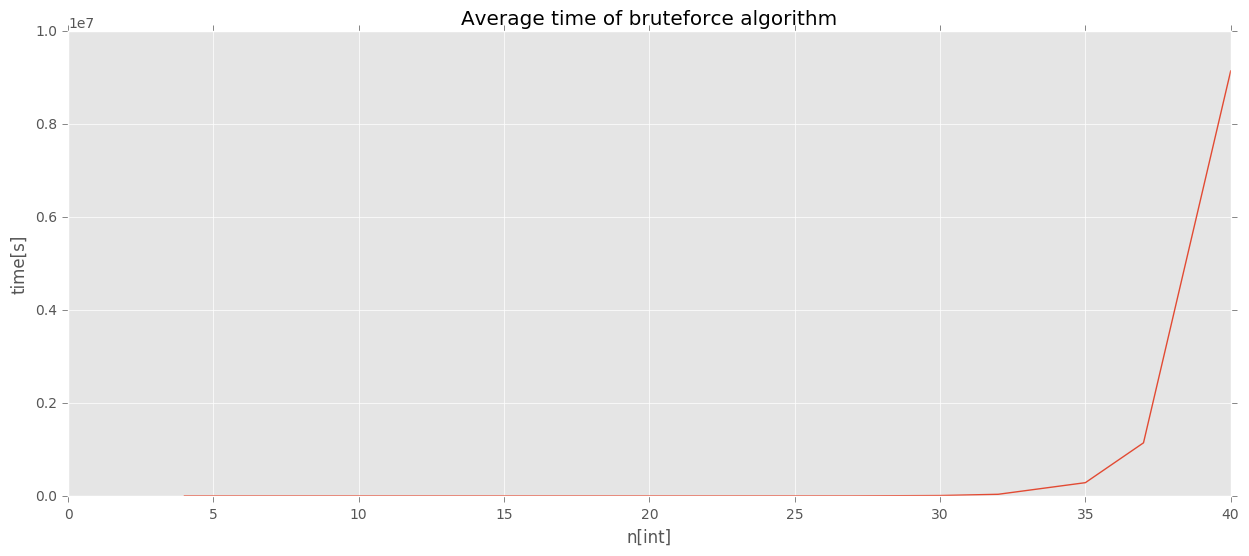

In [230]:
plt.plot(n_list, avg_brute_time)
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.title('Average time of bruteforce algorithm')

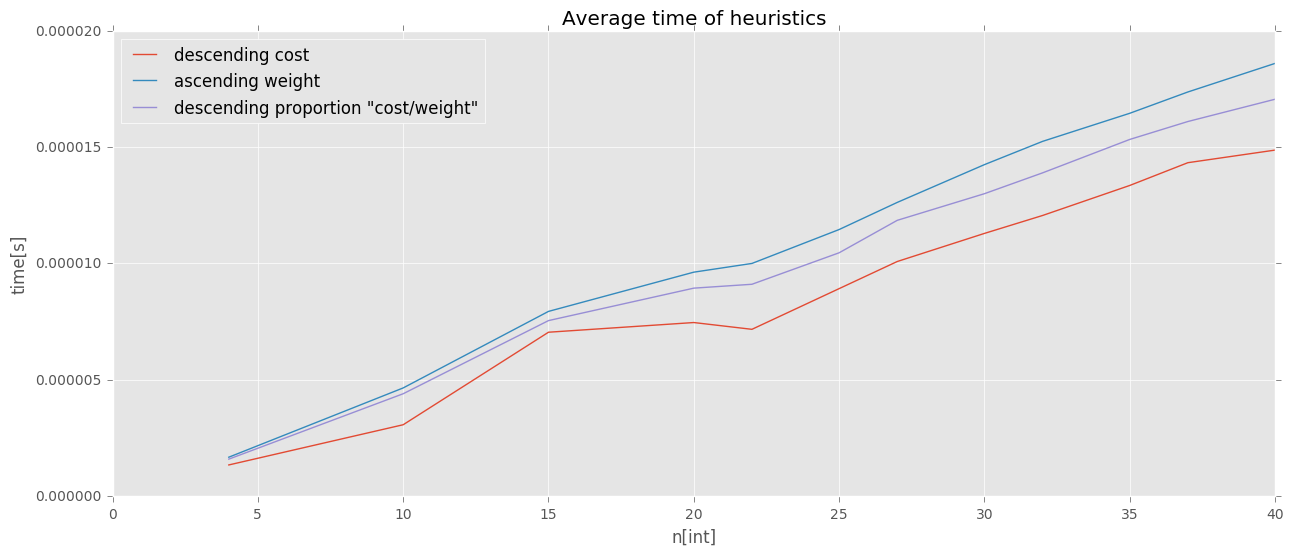

In [231]:
plt.plot(n_list, avg_by_cost_time, label='descending cost')
plt.plot(n_list, avg_by_weight_time, label='ascending weight')
plt.plot(n_list, avg_by_prop_time, label='descending proportion "cost/weight"')
plt.xlabel('n[int]')
plt.ylabel('time[s]')
plt.legend(loc='best')
plt.title('Average time of heuristics')

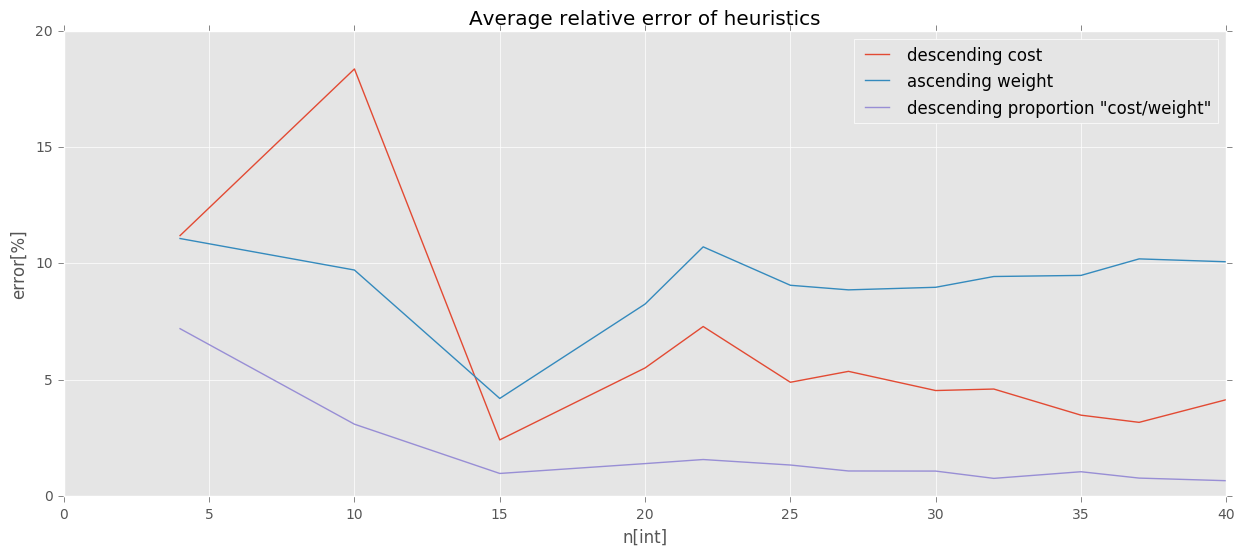

In [232]:
plt.plot(n_list, [x*100 for x in avg_by_cost_error], label='descending cost')
plt.plot(n_list, [x*100 for x in avg_by_weight_error], label='ascending weight')
plt.plot(n_list, [x*100 for x in avg_by_prop_error], label='descending proportion "cost/weight"')
plt.xlabel('n[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Average relative error of heuristics')

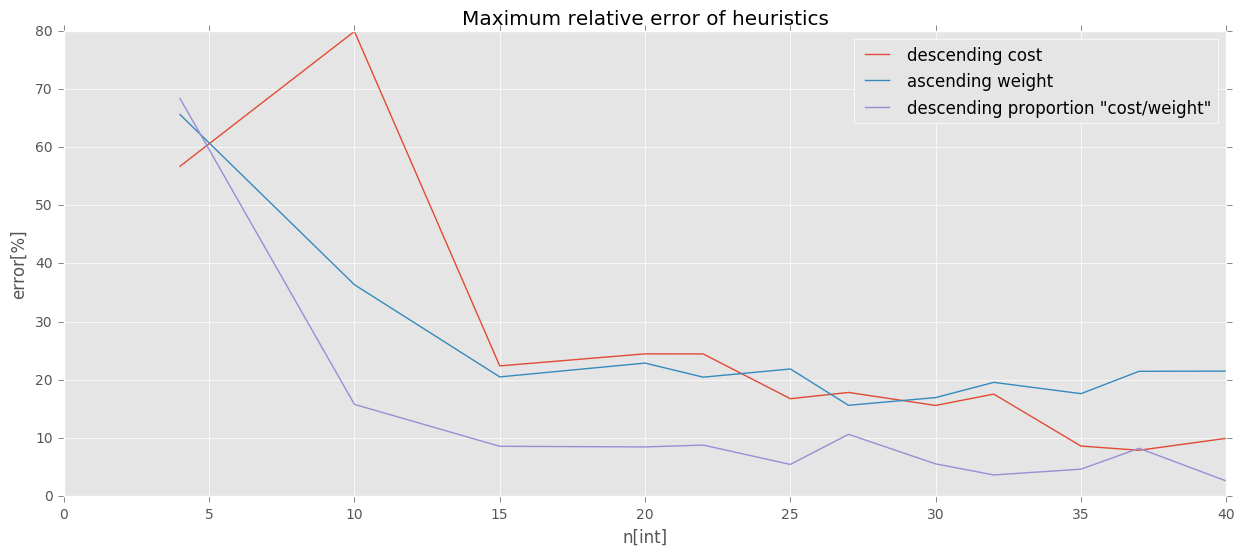

In [233]:
plt.plot(n_list, [x*100 for x in max_by_cost_error], label='descending cost')
plt.plot(n_list, [x*100 for x in max_by_weight_error], label='ascending weight')
plt.plot(n_list, [x*100 for x in max_by_prop_error], label='descending proportion "cost/weight"')
plt.xlabel('n[int]')
plt.ylabel('error[%]')
plt.legend(loc='best')
plt.title('Maximum relative error of heuristics')